<img src="NotebookAddons/blackboard-banner.png" width="100%" />

# Preparing a HyP3 InSAR Stack for MintPy

**Author**: Alex Lewandowski; University of Alaska Fairbanks
 
Based on [prep_hyp3_for_mintpy.ipynb](https://github.com/ASFHyP3/hyp3-docs) by Jiang Zhu; University of Alaska Fairbanks

<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" />

**Important Note about JupyterHub**
Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.

In [8]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [9]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/insar_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "insar_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "insar_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "insar_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

## 0. Importing Relevant Python Packages

In this notebook we will use the following scientific libraries:
- [GDAL](https://www.gdal.org/) is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.

**Our first step is to import gdal and other needed packages**

In [1]:
import copy
from datetime import datetime, timedelta
import ipywidgets as widgets
from itertools import chain
import json
from pathlib import Path
import re
import requests
from tqdm import tqdm
from typing import Union

import numpy as np
from osgeo import gdal
import pyproj
from pyproj import Transformer
import pandas

import opensarlab_lib as asfn

from hyp3_sdk import Batch, HyP3

%matplotlib widget

## 1. Load Your Own Data Stack Into the Notebook

This notebook assumes that you are accessing an InSAR time series created using the [Alaska Satellite Facility's](https://www.asf.alaska.edu/) value-added product system HyP3, available via [ASF Data Search/Vertex](https://search.asf.alaska.edu/). HyP3 is an ASF service used to prototype value added products and provide them to users to collect feedback.

You can access HyP3 on-demand products from your HyP3 account or from publically available, pre-processed SARVIEWS Event data. https://sarviews-hazards.alaska.edu/

Before downloading anything, create an analysis directory to hold your data.

**Select or create a working directory for the analysis:**

In [2]:
while True:
    print(f"Current working directory: {Path.cwd()}")
    data_dir = Path(input(f"\nPlease enter the name of a directory in which to store your data for this analysis."))
    if data_dir == Path('.'):
        continue
    if data_dir.is_dir():
        contents = data_dir.glob('*')
        if len(list(contents)) > 0:
            choice = asfn.handle_old_data(data_dir)
            if choice == 1:
                if data_dir.exists():
                    shutil.rmtree(data_dir)
                data_dir.mkdir()
                break
            elif choice == 2:
                break
            else:
                clear_output()
                continue
        else:
            break
    else:
        data_dir.mkdir()
        break

Current working directory: /home/jovyan/notebooks/SAR_Training/English/Master



Please enter the name of a directory in which to store your data for this analysis. test


**Define absolute path to  analysis directory:**

In [3]:
analysis_directory = Path.cwd()/(data_dir)
print(f"analysis_directory: {analysis_directory}")


analysis_directory: /home/jovyan/notebooks/SAR_Training/English/Master/test


In [4]:
def dates_from_product_name(product_name):
    regex = "[0-9]{8}T[0-9]{6}_[0-9]{8}T[0-9]{6}"
    results = re.search(regex, product_name)
    if results:
        return results.group(0)
    else:
        return None

### *** **IMPORTANT NOTEBOOK CHANGE** ***

**This notebook previously contained a section for downloading pre-processed volcanic and earthquake event data from SARVIEWS**

SARVIEWS is now hosted on [ASF Data-Search (Vertex)](https://search.asf.alaska.edu/).

The previous SARVIEWS section of this notebook was just a temporary work-around. It is much easier to organize smallbaseline InSAR stacks of SARVIEWS products in Vertex and then download them with the Vertex provided download script.

**Create a HyP3 object and authenticate:**

In [5]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  kroy0001
NASA Earthdata Login password:  ········


**List projects containing active InSAR products and select one:**

Your HyP3 InSAR project should include DEMs, which are available as options when submitting a HyP3 project

In [6]:
from IPython.display import Markdown
from IPython.display import display
from tqdm.notebook import trange, tqdm

my_hyp3_info = hyp3.my_info()
active_projects = dict()

print("Checking all HyP3 projects for current INSAR_GAMMA jobs")
for project in tqdm(my_hyp3_info['job_names']):
    batch = Batch()
    batch = hyp3.find_jobs(name=project, job_type='INSAR_GAMMA').filter_jobs(running=False, include_expired=False)
    if len(batch) > 0:
        active_projects.update({batch.jobs[0].name: batch})

if len(active_projects) > 0:
    display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>"))
    print('\nSelect a Project:')
    project_select = asfn.select_parameter(active_projects.keys())
    display(project_select)
else:
    print("Found no active projects containing InSAR products")

Checking all HyP3 projects for current INSAR_GAMMA jobs


  0%|          | 0/3 [00:00<?, ?it/s]

<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>


Select a Project:


RadioButtons(layout=Layout(min_width='800px'), options=('hamirpur', 'joshimath', 'siliguri'), value='hamirpur'…

**Select a date range of products to download:**

In [7]:
jobs = active_projects[project_select.value]

display(Markdown("<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>"))
print('\nSelect a Date Range:')
dates = asfn.get_job_dates(jobs)
date_picker = asfn.gui_date_picker(dates)
display(date_picker)

<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>


Select a Date Range:


SelectionRangeSlider(description='Dates', index=(0, 756), layout=Layout(width='500px'), options=((' 01/05/2021…

**Save the selected date range and remove products falling outside of it:**

In [8]:
date_range = asfn.get_slider_vals(date_picker)
date_range[0] = date_range[0].date()
date_range[1] = date_range[1].date()
print(f"Date Range: {str(date_range[0])} to {str(date_range[1])}")
jobs = asfn.filter_jobs_by_date(jobs, date_range)

Date Range: 2021-01-05 to 2023-01-31


**Gather the available paths and orbit directions for the remaining products:**

In [9]:
display(Markdown("<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>"))
asfn.set_paths_orbits(jobs)
paths = set()
orbit_directions = set()
for p in jobs:
    paths.add(p.path)
    orbit_directions.add(p.orbit_direction)
display(Markdown(f"<text style=color:blue><text style='font-size:175%;'>Done.</text></text>"))

<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>

<text style=color:blue><text style='font-size:175%;'>Done.</text></text>

---
**Select a path:**

This notebook does not currently support merging InSAR products in multiple paths

In [10]:
display(Markdown("<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Path:')
path_choice = asfn.select_parameter(paths)
display(path_choice)

<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Path:


RadioButtons(layout=Layout(min_width='800px'), options=(48,), value=48)

**Save the selected flight path/s:**

In [11]:
flight_path = path_choice.value
if flight_path:
    if flight_path:
        print(f"Flight Path: {flight_path}")
    else:
        print('Flight Path: All Paths')
else:
    print("WARNING: You must select a flight path in the previous cell, then rerun this cell.")

Flight Path: 48


**Select an orbit direction:**

In [12]:
if len(orbit_directions) > 1:
    display(Markdown("<text style='color:red;'>Note: After selecting a flight direction, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:red;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Flight Direction:')
direction_choice = asfn.select_parameter(orbit_directions, 'Direction:')
display(direction_choice)


Select a Flight Direction:


RadioButtons(description='Direction:', layout=Layout(min_width='800px'), options=('DESCENDING',), value='DESCE…

**Save the selected orbit direction:**

In [13]:
direction = direction_choice.value
print(f"Orbit Direction: {direction}")

Orbit Direction: DESCENDING


**Filter jobs by path and orbit direction:**

In [14]:
jobs = asfn.filter_jobs_by_path(jobs, [flight_path])
jobs = asfn.filter_jobs_by_orbit(jobs, direction)
print(f"There are {len(jobs)} products to download.")

There are 159 products to download.


**Download the products, unzip them into a directory named after the product type, and delete the zip files:**

In [15]:
print(f"\nProject: {jobs.jobs[0].name}")
project_zips = jobs.download_files(analysis_directory)
for z in project_zips:
    asfn.asf_unzip(str(analysis_directory), str(z))
    z.unlink()


Project: siliguri


  0%|          | 0/159 [00:00<?, ?it/s]

S1AA_20221108T000346_20221202T000345_VVP024_INT80_G_ueF_62FB.zip:   0%|          | 0/228908068 [00:00<?, ?it/s…

S1AA_20221108T000346_20221120T000346_VVP012_INT80_G_ueF_92A0.zip:   0%|          | 0/228385103 [00:00<?, ?it/s…

S1AA_20221214T000345_20230107T000343_VVP024_INT80_G_ueF_4A45.zip:   0%|          | 0/227337729 [00:00<?, ?it/s…

S1AA_20221202T000345_20221226T000344_VVP024_INT80_G_ueF_9F4A.zip:   0%|          | 0/228163294 [00:00<?, ?it/s…

S1AA_20221108T000346_20221214T000345_VVP036_INT80_G_ueF_6ED1.zip:   0%|          | 0/231526023 [00:00<?, ?it/s…

S1AA_20221027T000346_20221108T000346_VVP012_INT80_G_ueF_34FD.zip:   0%|          | 0/229019495 [00:00<?, ?it/s…

S1AA_20221226T000344_20230107T000343_VVP012_INT80_G_ueF_DF30.zip:   0%|          | 0/226336783 [00:00<?, ?it/s…

S1AA_20221120T000346_20221226T000344_VVP036_INT80_G_ueF_A244.zip:   0%|          | 0/228312900 [00:00<?, ?it/s…

S1AA_20221027T000346_20221120T000346_VVP024_INT80_G_ueF_9777.zip:   0%|          | 0/229684061 [00:00<?, ?it/s…

S1AA_20221120T000346_20221202T000345_VVP012_INT80_G_ueF_6F79.zip:   0%|          | 0/228236944 [00:00<?, ?it/s…

S1AA_20221226T000344_20230131T000343_VVR036_INT80_G_ueF_8BA0.zip:   0%|          | 0/228761125 [00:00<?, ?it/s…

S1AA_20221226T000344_20230119T000342_VVR024_INT80_G_ueF_B456.zip:   0%|          | 0/227894074 [00:00<?, ?it/s…

S1AA_20221027T000346_20221202T000345_VVP036_INT80_G_ueF_5184.zip:   0%|          | 0/229501522 [00:00<?, ?it/s…

S1AA_20221202T000345_20230107T000343_VVP036_INT80_G_ueF_26A5.zip:   0%|          | 0/228731286 [00:00<?, ?it/s…

S1AA_20230107T000343_20230131T000343_VVR024_INT80_G_ueF_6178.zip:   0%|          | 0/228188184 [00:00<?, ?it/s…

S1AA_20221202T000345_20221214T000345_VVP012_INT80_G_ueF_EB85.zip:   0%|          | 0/227476534 [00:00<?, ?it/s…

S1AA_20221214T000345_20230119T000342_VVR036_INT80_G_ueF_A594.zip:   0%|          | 0/229815993 [00:00<?, ?it/s…

S1AA_20221120T000346_20221214T000345_VVP024_INT80_G_ueF_3F22.zip:   0%|          | 0/228171090 [00:00<?, ?it/s…

S1AA_20221214T000345_20221226T000344_VVP012_INT80_G_ueF_383A.zip:   0%|          | 0/226358710 [00:00<?, ?it/s…

S1AA_20220617T000341_20220629T000342_VVP012_INT80_G_ueF_F718.zip:   0%|          | 0/231182854 [00:00<?, ?it/s…

S1AA_20220921T000345_20221003T000346_VVP012_INT80_G_ueF_D6BD.zip:   0%|          | 0/228866406 [00:00<?, ?it/s…

S1AA_20220711T000342_20220804T000344_VVP024_INT80_G_ueF_A734.zip:   0%|          | 0/231089355 [00:00<?, ?it/s…

S1AA_20220816T000345_20220921T000345_VVP036_INT80_G_ueF_9057.zip:   0%|          | 0/231386373 [00:00<?, ?it/s…

S1AA_20220816T000345_20220828T000345_VVP012_INT80_G_ueF_5AAF.zip:   0%|          | 0/230677248 [00:00<?, ?it/s…

S1AA_20220711T000342_20220723T000343_VVP012_INT80_G_ueF_0D94.zip:   0%|          | 0/229996614 [00:00<?, ?it/s…

S1AA_20220629T000342_20220723T000343_VVP024_INT80_G_ueF_AA74.zip:   0%|          | 0/231612726 [00:00<?, ?it/s…

S1AA_20221003T000346_20221027T000346_VVP024_INT80_G_ueF_194D.zip:   0%|          | 0/229328959 [00:00<?, ?it/s…

S1AA_20221003T000346_20221108T000346_VVP036_INT80_G_ueF_2A79.zip:   0%|          | 0/230440026 [00:00<?, ?it/s…

S1AA_20220723T000343_20220828T000345_VVP036_INT80_G_ueF_FAB5.zip:   0%|          | 0/230777270 [00:00<?, ?it/s…

S1AA_20220617T000341_20220723T000343_VVP036_INT80_G_ueF_BABE.zip:   0%|          | 0/231564858 [00:00<?, ?it/s…

S1AA_20220804T000344_20220828T000345_VVP024_INT80_G_ueF_F56A.zip:   0%|          | 0/231799277 [00:00<?, ?it/s…

S1AA_20220629T000342_20220804T000344_VVP036_INT80_G_ueF_3E35.zip:   0%|          | 0/232339701 [00:00<?, ?it/s…

S1AA_20220828T000345_20221003T000346_VVP036_INT80_G_ueF_9E41.zip:   0%|          | 0/230021138 [00:00<?, ?it/s…

S1AA_20220723T000343_20220804T000344_VVP012_INT80_G_ueF_538F.zip:   0%|          | 0/231708684 [00:00<?, ?it/s…

S1AA_20220617T000341_20220711T000342_VVP024_INT80_G_ueF_C3ED.zip:   0%|          | 0/231263921 [00:00<?, ?it/s…

S1AA_20220629T000342_20220711T000342_VVP012_INT80_G_ueF_23CD.zip:   0%|          | 0/230830352 [00:00<?, ?it/s…

S1AA_20220723T000343_20220816T000345_VVP024_INT80_G_ueF_C46C.zip:   0%|          | 0/230407408 [00:00<?, ?it/s…

S1AA_20220711T000342_20220816T000345_VVP036_INT80_G_ueF_AD2B.zip:   0%|          | 0/231483005 [00:00<?, ?it/s…

S1AA_20220804T000344_20220816T000345_VVP012_INT80_G_ueF_9431.zip:   0%|          | 0/231557374 [00:00<?, ?it/s…

S1AA_20220430T000338_20220605T000340_VVP036_INT80_G_ueF_0350.zip:   0%|          | 0/229994404 [00:00<?, ?it/s…

S1AA_20220430T000338_20220512T000338_VVP012_INT80_G_ueF_A878.zip:   0%|          | 0/229426761 [00:00<?, ?it/s…

S1AA_20220301T000336_20220406T000337_VVP036_INT80_G_ueF_A243.zip:   0%|          | 0/230446500 [00:00<?, ?it/s…

S1AA_20220605T000340_20220711T000342_VVP036_INT80_G_ueF_FC8C.zip:   0%|          | 0/231654495 [00:00<?, ?it/s…

S1AA_20220406T000337_20220512T000338_VVP036_INT80_G_ueF_131D.zip:   0%|          | 0/229371958 [00:00<?, ?it/s…

S1AA_20220313T000336_20220325T000337_VVP012_INT80_G_ueF_9AEF.zip:   0%|          | 0/229560777 [00:00<?, ?it/s…

S1AA_20220418T000337_20220430T000338_VVP012_INT80_G_ueF_3B5F.zip:   0%|          | 0/230440111 [00:00<?, ?it/s…

S1AA_20220512T000338_20220605T000340_VVP024_INT80_G_ueF_7213.zip:   0%|          | 0/230021455 [00:00<?, ?it/s…

S1AA_20220301T000336_20220325T000337_VVP024_INT80_G_ueF_3266.zip:   0%|          | 0/229076367 [00:00<?, ?it/s…

S1AA_20220325T000337_20220430T000338_VVP036_INT80_G_ueF_15DB.zip:   0%|          | 0/229875998 [00:00<?, ?it/s…

S1AA_20220313T000336_20220418T000337_VVP036_INT80_G_ueF_C040.zip:   0%|          | 0/229639018 [00:00<?, ?it/s…

S1AA_20220512T000338_20220617T000341_VVP036_INT80_G_ueF_137C.zip:   0%|          | 0/229783894 [00:00<?, ?it/s…

S1AA_20220325T000337_20220406T000337_VVP012_INT80_G_ueF_5BD2.zip:   0%|          | 0/228738189 [00:00<?, ?it/s…

S1AA_20220325T000337_20220418T000337_VVP024_INT80_G_ueF_B55F.zip:   0%|          | 0/229171255 [00:00<?, ?it/s…

S1AA_20220313T000336_20220406T000337_VVP024_INT80_G_ueF_24C9.zip:   0%|          | 0/229989280 [00:00<?, ?it/s…

S1AA_20220406T000337_20220418T000337_VVP012_INT80_G_ueF_463D.zip:   0%|          | 0/228872838 [00:00<?, ?it/s…

S1AA_20220406T000337_20220430T000338_VVP024_INT80_G_ueF_FD83.zip:   0%|          | 0/230167230 [00:00<?, ?it/s…

S1AA_20220418T000337_20220512T000338_VVP024_INT80_G_ueF_AD0F.zip:   0%|          | 0/229958433 [00:00<?, ?it/s…

S1AA_20220605T000340_20220617T000341_VVP012_INT80_G_ueF_D469.zip:   0%|          | 0/230586914 [00:00<?, ?it/s…

S1AA_20220605T000340_20220629T000342_VVP024_INT80_G_ueF_33D1.zip:   0%|          | 0/231226246 [00:00<?, ?it/s…

S1AA_20220205T000336_20220313T000336_VVP036_INT80_G_ueF_6B60.zip:   0%|          | 0/229459860 [00:00<?, ?it/s…

S1AA_20211219T000339_20220112T000338_VVP024_INT80_G_ueF_B5D9.zip:   0%|          | 0/228667007 [00:00<?, ?it/s…

S1AA_20220124T000337_20220205T000336_VVP012_INT80_G_ueF_D07D.zip:   0%|          | 0/229280134 [00:00<?, ?it/s…

S1AA_20211231T000338_20220112T000338_VVP012_INT80_G_ueF_0C7A.zip:   0%|          | 0/226352857 [00:00<?, ?it/s…

S1AA_20211219T000339_20211231T000338_VVP012_INT80_G_ueF_C209.zip:   0%|          | 0/226951602 [00:00<?, ?it/s…

S1AA_20211231T000338_20220124T000337_VVP024_INT80_G_ueF_0F46.zip:   0%|          | 0/227993514 [00:00<?, ?it/s…

S1AA_20220124T000337_20220217T000336_VVP024_INT80_G_ueF_483E.zip:   0%|          | 0/228077933 [00:00<?, ?it/s…

S1AA_20220217T000336_20220301T000336_VVP012_INT80_G_ueF_FA3E.zip:   0%|          | 0/227288124 [00:00<?, ?it/s…

S1AA_20220217T000336_20220313T000336_VVP024_INT80_G_ueF_8B8D.zip:   0%|          | 0/230548171 [00:00<?, ?it/s…

S1AA_20220217T000336_20220325T000337_VVP036_INT80_G_ueF_3508.zip:   0%|          | 0/230534252 [00:00<?, ?it/s…

S1AA_20220205T000336_20220301T000336_VVP024_INT80_G_ueF_6DBA.zip:   0%|          | 0/229422267 [00:00<?, ?it/s…

S1AA_20220112T000338_20220217T000336_VVP036_INT80_G_ueF_744F.zip:   0%|          | 0/228683734 [00:00<?, ?it/s…

S1AA_20211231T000338_20220205T000336_VVP036_INT80_G_ueF_A3A5.zip:   0%|          | 0/229416538 [00:00<?, ?it/s…

S1AA_20220301T000336_20220313T000336_VVP012_INT80_G_ueF_425C.zip:   0%|          | 0/228009335 [00:00<?, ?it/s…

S1AA_20211219T000339_20220124T000337_VVP036_INT80_G_ueF_231E.zip:   0%|          | 0/229036025 [00:00<?, ?it/s…

S1AA_20220112T000338_20220205T000336_VVP024_INT80_G_ueF_C7F5.zip:   0%|          | 0/229377787 [00:00<?, ?it/s…

S1AA_20220112T000338_20220124T000337_VVP012_INT80_G_ueF_6C5E.zip:   0%|          | 0/226786947 [00:00<?, ?it/s…

S1AA_20220205T000336_20220217T000336_VVP012_INT80_G_ueF_F45B.zip:   0%|          | 0/227938132 [00:00<?, ?it/s…

S1AA_20220124T000337_20220301T000336_VVP036_INT80_G_ueF_76FE.zip:   0%|          | 0/229232166 [00:00<?, ?it/s…

S1AA_20211207T000339_20220112T000338_VVP036_INT80_G_ueF_56DC.zip:   0%|          | 0/230461878 [00:00<?, ?it/s…

S1AA_20211113T000340_20211125T000340_VVP012_INT80_G_ueF_7B70.zip:   0%|          | 0/228619593 [00:00<?, ?it/s…

S1AA_20211020T000340_20211101T000340_VVP012_INT80_G_ueF_69CC.zip:   0%|          | 0/230040157 [00:00<?, ?it/s…

S1AA_20211125T000340_20211219T000339_VVP024_INT80_G_ueF_79D7.zip:   0%|          | 0/228585100 [00:00<?, ?it/s…

S1AA_20211020T000340_20211125T000340_VVP036_INT80_G_ueF_9634.zip:   0%|          | 0/229597686 [00:00<?, ?it/s…

S1AA_20211008T000340_20211020T000340_VVP012_INT80_G_ueF_E49A.zip:   0%|          | 0/230496210 [00:00<?, ?it/s…

S1AA_20211207T000339_20211219T000339_VVP012_INT80_G_ueF_ADD8.zip:   0%|          | 0/226747954 [00:00<?, ?it/s…

S1AA_20211207T000339_20211231T000338_VVP024_INT80_G_ueF_5BA9.zip:   0%|          | 0/228973012 [00:00<?, ?it/s…

S1AA_20211113T000340_20211207T000339_VVP024_INT80_G_ueF_5F27.zip:   0%|          | 0/229316195 [00:00<?, ?it/s…

S1AA_20211101T000340_20211113T000340_VVP012_INT80_G_ueF_16EB.zip:   0%|          | 0/228991336 [00:00<?, ?it/s…

S1AA_20211113T000340_20211219T000339_VVP036_INT80_G_ueF_D377.zip:   0%|          | 0/229434403 [00:00<?, ?it/s…

S1AA_20211125T000340_20211207T000339_VVP012_INT80_G_ueF_2A5C.zip:   0%|          | 0/226562659 [00:00<?, ?it/s…

S1AA_20211008T000340_20211101T000340_VVP024_INT80_G_ueF_C8A3.zip:   0%|          | 0/230937306 [00:00<?, ?it/s…

S1AA_20211101T000340_20211207T000339_VVP036_INT80_G_ueF_39FF.zip:   0%|          | 0/230502849 [00:00<?, ?it/s…

S1AA_20211101T000340_20211125T000340_VVP024_INT80_G_ueF_5548.zip:   0%|          | 0/230200788 [00:00<?, ?it/s…

S1AA_20211008T000340_20211113T000340_VVP036_INT80_G_ueF_2E7F.zip:   0%|          | 0/230837722 [00:00<?, ?it/s…

S1AA_20210926T000340_20211008T000340_VVP012_INT80_G_ueF_4949.zip:   0%|          | 0/229568152 [00:00<?, ?it/s…

S1AA_20211125T000340_20211231T000338_VVP036_INT80_G_ueF_D66A.zip:   0%|          | 0/228828663 [00:00<?, ?it/s…

S1AA_20211020T000340_20211113T000340_VVP024_INT80_G_ueF_F4A6.zip:   0%|          | 0/230815315 [00:00<?, ?it/s…

S1AA_20210926T000340_20211101T000340_VVP036_INT80_G_ueF_2A6C.zip:   0%|          | 0/230042433 [00:00<?, ?it/s…

S1AA_20210926T000340_20211020T000340_VVP024_INT80_G_ueF_BC7E.zip:   0%|          | 0/232036507 [00:00<?, ?it/s…

S1AA_20210914T000340_20211020T000340_VVP036_INT80_G_ueF_6274.zip:   0%|          | 0/231877940 [00:00<?, ?it/s…

S1AA_20210716T000337_20210821T000339_VVP036_INT80_G_ueF_4E82.zip:   0%|          | 0/231914319 [00:00<?, ?it/s…

S1AA_20210704T000336_20210728T000337_VVP024_INT80_G_ueF_0B39.zip:   0%|          | 0/231825763 [00:00<?, ?it/s…

S1AA_20210716T000337_20210728T000337_VVP012_INT80_G_ueF_84BA.zip:   0%|          | 0/230552147 [00:00<?, ?it/s…

S1AA_20210902T000339_20210914T000340_VVP012_INT80_G_ueF_EA03.zip:   0%|          | 0/231531770 [00:00<?, ?it/s…

S1AA_20210821T000339_20210902T000339_VVP012_INT80_G_ueF_B0A4.zip:   0%|          | 0/231045199 [00:00<?, ?it/s…

S1AA_20210728T000337_20210821T000339_VVP024_INT80_G_ueF_C5FB.zip:   0%|          | 0/230494002 [00:00<?, ?it/s…

S1AA_20210914T000340_20211008T000340_VVP024_INT80_G_ueF_08C3.zip:   0%|          | 0/230585070 [00:00<?, ?it/s…

S1AA_20210728T000337_20210809T000338_VVP012_INT80_G_ueF_C79E.zip:   0%|          | 0/230857755 [00:00<?, ?it/s…

S1AA_20210902T000339_20210926T000340_VVP024_INT80_G_ueF_57DB.zip:   0%|          | 0/231242517 [00:00<?, ?it/s…

S1AA_20210809T000338_20210821T000339_VVP012_INT80_G_ueF_4904.zip:   0%|          | 0/231102942 [00:00<?, ?it/s…

S1AA_20210809T000338_20210914T000340_VVP036_INT80_G_ueF_198E.zip:   0%|          | 0/231067392 [00:00<?, ?it/s…

S1AA_20210728T000337_20210902T000339_VVP036_INT80_G_ueF_7511.zip:   0%|          | 0/232307014 [00:00<?, ?it/s…

S1AA_20210902T000339_20211008T000340_VVP036_INT80_G_ueF_258C.zip:   0%|          | 0/230535548 [00:00<?, ?it/s…

S1AA_20210716T000337_20210809T000338_VVP024_INT80_G_ueF_BF31.zip:   0%|          | 0/231634960 [00:00<?, ?it/s…

S1AA_20210821T000339_20210926T000340_VVP036_INT80_G_ueF_CB4A.zip:   0%|          | 0/229666607 [00:00<?, ?it/s…

S1AA_20210821T000339_20210914T000340_VVP024_INT80_G_ueF_9EEF.zip:   0%|          | 0/231203496 [00:00<?, ?it/s…

S1AA_20210704T000336_20210809T000338_VVP036_INT80_G_ueF_0573.zip:   0%|          | 0/232025793 [00:00<?, ?it/s…

S1AA_20210809T000338_20210902T000339_VVP024_INT80_G_ueF_C1D8.zip:   0%|          | 0/231986316 [00:00<?, ?it/s…

S1AA_20210914T000340_20210926T000340_VVP012_INT80_G_ueF_7E92.zip:   0%|          | 0/230069729 [00:00<?, ?it/s…

S1AA_20210517T000333_20210529T000334_VVP012_INT80_G_ueF_3084.zip:   0%|          | 0/229943533 [00:00<?, ?it/s…

S1AA_20210622T000335_20210704T000336_VVP012_INT80_G_ueF_7842.zip:   0%|          | 0/230345474 [00:00<?, ?it/s…

S1AA_20210529T000334_20210622T000335_VVP024_INT80_G_ueF_C609.zip:   0%|          | 0/230385185 [00:00<?, ?it/s…

S1AA_20210610T000334_20210704T000336_VVP024_INT80_G_ueF_69C2.zip:   0%|          | 0/229965259 [00:00<?, ?it/s…

S1AA_20210505T000332_20210517T000333_VVP012_INT80_G_ueF_1FF8.zip:   0%|          | 0/228993354 [00:00<?, ?it/s…

S1AA_20210622T000335_20210716T000337_VVP024_INT80_G_ueF_90B2.zip:   0%|          | 0/230023958 [00:00<?, ?it/s…

S1AA_20210423T000332_20210505T000332_VVP012_INT80_G_ueF_A26D.zip:   0%|          | 0/228888543 [00:00<?, ?it/s…

S1AA_20210423T000332_20210529T000334_VVP036_INT80_G_ueF_4A90.zip:   0%|          | 0/231151204 [00:00<?, ?it/s…

S1AA_20210330T000331_20210505T000332_VVP036_INT80_G_ueF_84C3.zip:   0%|          | 0/230957445 [00:00<?, ?it/s…

S1AA_20210517T000333_20210622T000335_VVP036_INT80_G_ueF_F5DF.zip:   0%|          | 0/229839132 [00:00<?, ?it/s…

S1AA_20210517T000333_20210610T000334_VVP024_INT80_G_ueF_1D73.zip:   0%|          | 0/230101351 [00:00<?, ?it/s…

S1AA_20210622T000335_20210728T000337_VVP036_INT80_G_ueF_A7CE.zip:   0%|          | 0/231358087 [00:00<?, ?it/s…

S1AA_20210610T000334_20210622T000335_VVP012_INT80_G_ueF_F355.zip:   0%|          | 0/229752794 [00:00<?, ?it/s…

S1AA_20210529T000334_20210704T000336_VVP036_INT80_G_ueF_CEDF.zip:   0%|          | 0/229780616 [00:00<?, ?it/s…

S1AA_20210704T000336_20210716T000337_VVP012_INT80_G_ueF_A6AF.zip:   0%|          | 0/230317571 [00:00<?, ?it/s…

S1AA_20210529T000334_20210610T000334_VVP012_INT80_G_ueF_B904.zip:   0%|          | 0/229333627 [00:00<?, ?it/s…

S1AA_20210505T000332_20210529T000334_VVP024_INT80_G_ueF_C207.zip:   0%|          | 0/229481925 [00:00<?, ?it/s…

S1AA_20210423T000332_20210517T000333_VVP024_INT80_G_ueF_0742.zip:   0%|          | 0/229974256 [00:00<?, ?it/s…

S1AA_20210610T000334_20210716T000337_VVP036_INT80_G_ueF_CDFF.zip:   0%|          | 0/229826740 [00:00<?, ?it/s…

S1AA_20210505T000332_20210610T000334_VVP036_INT80_G_ueF_5ABE.zip:   0%|          | 0/231165819 [00:00<?, ?it/s…

S1AA_20210222T000331_20210306T000331_VVP012_INT80_G_ueF_238D.zip:   0%|          | 0/228008226 [00:00<?, ?it/s…

S1AA_20210222T000331_20210330T000331_VVP036_INT80_G_ueF_4E27.zip:   0%|          | 0/229687351 [00:00<?, ?it/s…

S1AA_20210129T000331_20210222T000331_VVP024_INT80_G_ueF_CA03.zip:   0%|          | 0/228984757 [00:00<?, ?it/s…

S1AA_20210105T000332_20210129T000331_VVP024_INT80_G_ueF_722B.zip:   0%|          | 0/228518809 [00:00<?, ?it/s…

S1AA_20210117T000332_20210222T000331_VVP036_INT80_G_ueF_BAB8.zip:   0%|          | 0/230278217 [00:00<?, ?it/s…

S1AA_20210318T000330_20210330T000331_VVP012_INT80_G_ueF_9BDD.zip:   0%|          | 0/227976916 [00:00<?, ?it/s…

S1AA_20210306T000331_20210318T000330_VVP012_INT80_G_ueF_2B1A.zip:   0%|          | 0/228393763 [00:00<?, ?it/s…

S1AA_20210105T000332_20210117T000332_VVP012_INT80_G_ueF_A489.zip:   0%|          | 0/227276393 [00:00<?, ?it/s…

S1AA_20210318T000330_20210423T000332_VVP036_INT80_G_ueF_75B2.zip:   0%|          | 0/229057754 [00:00<?, ?it/s…

S1AA_20210210T000331_20210318T000330_VVP036_INT80_G_ueF_46C1.zip:   0%|          | 0/230245725 [00:00<?, ?it/s…

S1AA_20210306T000331_20210330T000331_VVP024_INT80_G_ueF_4C27.zip:   0%|          | 0/230708329 [00:00<?, ?it/s…

S1AA_20210210T000331_20210222T000331_VVP012_INT80_G_ueF_4121.zip:   0%|          | 0/228337653 [00:00<?, ?it/s…

S1AA_20210222T000331_20210318T000330_VVP024_INT80_G_ueF_2933.zip:   0%|          | 0/230360419 [00:00<?, ?it/s…

S1AA_20210117T000332_20210210T000331_VVP024_INT80_G_ueF_7656.zip:   0%|          | 0/227515199 [00:00<?, ?it/s…

S1AA_20210105T000332_20210210T000331_VVP036_INT80_G_ueF_6AF6.zip:   0%|          | 0/229222813 [00:00<?, ?it/s…

S1AA_20210129T000331_20210306T000331_VVP036_INT80_G_ueF_5E52.zip:   0%|          | 0/229841444 [00:00<?, ?it/s…

S1AA_20210117T000332_20210129T000331_VVP012_INT80_G_ueF_0FB1.zip:   0%|          | 0/226918766 [00:00<?, ?it/s…

S1AA_20210330T000331_20210423T000332_VVP024_INT80_G_ueF_C5BB.zip:   0%|          | 0/230837224 [00:00<?, ?it/s…

S1AA_20210129T000331_20210210T000331_VVP012_INT80_G_ueF_5241.zip:   0%|          | 0/227403315 [00:00<?, ?it/s…

S1AA_20210210T000331_20210306T000331_VVP024_INT80_G_ueF_E020.zip:   0%|          | 0/229014826 [00:00<?, ?it/s…

Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221108T000346_20221202T000345_VVP024_INT80_G_ueF_62FB.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221108T000346_20221120T000346_VVP012_INT80_G_ueF_92A0.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221214T000345_20230107T000343_VVP024_INT80_G_ueF_4A45.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221202T000345_20221226T000344_VVP024_INT80_G_ueF_9F4A.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221108T000346_20221214T000345_VVP036_INT80_G_ueF_6ED1.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221027T000346_20221108T000346_VVP012_INT80_G_ueF_34FD.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20221226T000344_20230107T000343_VVP012_INT80_G_ueF_DF30.zip
Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/test/S

# 2. Confirm Presence of a DEM, Azimuth Angle Map, and Incidence Angle Map

- These are optional addon products for HyP3, which are necessary for MintPy
    - Incidence angle maps are included with HyP3 jobs when the `Include Look Vectors` option is selected.
    - DEMs are included with HyP3 jobs when the `Include DEM` option is selected
- This is an optional addon product for HyP3, which is necessary for MintPy if running the correct_SET (Solid Earth Tides) step
    - Azimuth angle maps are included with HyP3 jobs when the `Include Look Vectors` option is selected

**All of the above mentioned files will be included in an InSAR project if Set MintPy Options is selected when adding InSAR jobs to a project in ASF-Search (Vertex)**

In [16]:
dems = list(analysis_directory.glob('*/*dem*.tif'))
az_angle_maps = list(analysis_directory.glob('*/*lv_phi*.tif'))
inc_angle_maps = list(analysis_directory.glob('*/*lv_theta*.tif'))

if len(dems) > 0:
    print("Success: Found at least 1 DEM.")
else:
    raise FileNotFoundError("Failed to find at least 1 DEM. \
    \nYou will not be able to successfully run a MintPy time-series unless you reorder your HyP3 project \
with DEMS or provide one from another source.")
    
if len(az_angle_maps) > 0:
    print("Success: Found at least 1 Azimuth Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Azimuth Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Look Vectors' option selected.")
    
if len(inc_angle_maps) > 0:
    print("Success: Found at least 1 Incidence Angle Map.")
else:
    raise FileNotFoundError("Failed to find at least 1 Incidence Angle Map. \
    \nYou will not be able to successfully run a MintPy time-series unless your reorder your HyP3 project \
with 'Include Inc. Angle Map' option selected.")

Success: Found at least 1 DEM.
Success: Found at least 1 Azimuth Angle Map.
Success: Found at least 1 Incidence Angle Map.


# 3. Subset the Stack and Cleanup Unused Files

**Delete unneeded files:**

In [17]:
for pattern in ["xml","png","kmz","md.txt"]:
    unneeded_files = analysis_directory.glob(f"*/*.{pattern}")
    for file in unneeded_files:
        file.unlink()

**Subset the timeseries to your AOI:**

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


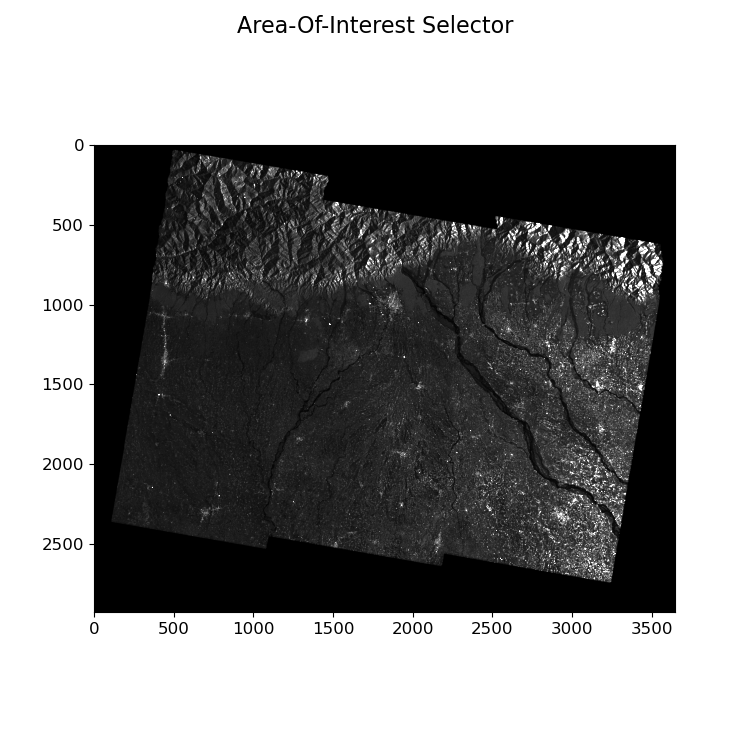

In [18]:
amp = list(analysis_directory.glob(f'*/*_amp.tif'))
merge_paths = ""

for pth in amp:
    merge_paths = f"{merge_paths} {pth}"

full_scene = analysis_directory/"full_scene.tif"
if full_scene.exists():
    full_scene.unlink()
gdal_command = f"gdal_merge.py -o {full_scene} {merge_paths}"
!{gdal_command}

image_file = f"{analysis_directory}/raster_stack.vrt"
!gdalbuildvrt -separate $image_file -overwrite $full_scene
img = gdal.Open(image_file)
rasterstack = img.ReadAsArray()

aoi = asfn.AOI_Selector(rasterstack, 7.5, 7.5)

**Convert the AOI plot's x,y values to georaphic coordinates:** 

In [20]:
geotrans = img.GetGeoTransform()

def geolocation(x, y, geotrans):
    return [geotrans[0]+x*geotrans[1], geotrans[3]+y*geotrans[5]]

try:
    ul = geolocation(aoi.x1, aoi.y1, geotrans)
    lr = geolocation(aoi.x2, aoi.y2, geotrans)
    print(f"AOI Corner Coordinates:")
    print(f"upper left corner: {ul}")
    print(f"lower right corner: {lr}")
except TypeError:
    print('TypeError')
    display(Markdown(f'<text style=color:red>This error may occur if an AOI was not selected.</text>'))
    display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))

AOI Corner Coordinates:
upper left corner: [498544.2107526882, 3029035.858064516]
lower right corner: [775120.1419354839, 2817211.823655914]


**Crop the stack to the AOI and reproject to lat-lon:**

In [23]:
fnames = list(analysis_directory.glob('*/*.tif'))
fnames.sort()
    

for i, fname in enumerate(fnames):
    clip = fname.parent/f"{fname.stem}_clip.tif"
    gdal.Translate(destName=str(clip), srcDS=str(fname), projWin=[ul[0], ul[1], lr[0], lr[1]])
    gdal.Warp(str(clip), str(clip), dstSRS='EPSG:4326', dstNodata=0)
    fname.unlink() 

ERROR 3: S1AA_20210105T000332_20210117T000332_VVP012_INT80_G_ueF_A489_amp_clip_clip.tif: Free disk space available is 470745456640 bytes, whereas 392526603391022976 are at least necessary. You can disable this check by defining the CHECK_DISK_FREE_SPACE configuration option to FALSE.
ERROR 4: /home/jovyan/notebooks/SAR_Training/English/Master/test/S1AA_20210105T000332_20210117T000332_VVP012_INT80_G_ueF_A489/S1AA_20210105T000332_20210117T000332_VVP012_INT80_G_ueF_A489_amp_clip_clip.tif: No such file or directory


TypeError: object of wrong GDALDatasetShadow

**Remove any subset scenes containing no data:**

In [22]:
fnames = list(analysis_directory.glob('*/*.tif*'))
fnames = [str(f) for f in fnames]
fnames.sort()

removed = []
for f in fnames:
    if not "dem" in str(f):
        raster = gdal.Open(f)
        if raster:
            band = raster.ReadAsArray()
            if np.count_nonzero(band) < 1:
                Path(f).unlink()
                removed.append(f)

if len(removed) == 0:
    print("No Geotiffs were removed")
else:
    print(f"{len(removed)} GeoTiffs removed:")
    for f in removed:
        print(f)

No Geotiffs were removed


In [ ]:
print("run")

# 4. Proceed to the MintPy Time-Series Notebook

**Run the code cell below for a link to the MintPy_Time_Series_From_Prepared_Data_Stack notebook:**

Describe what each notebook does in bottom links

In [26]:
# from pathlib import Path
from IPython.display import display, HTML

current = Path.cwd()
abs_path = Path('/home/jovyan/notebooks/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb')
relative_path = abs_path.relative_to(current)    

link_t = f"Open <a href='{relative_path}'>MintPy_Time_Series_From_Prepared_Data_Stack.ipynb</a> to run an InSAR time-series analysis on your data using MintPy"
html = HTML(link_t)
display(html)

*Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb - Version 1.2.0 - July 2022*
   
*Version Changes*

- *Remove SARVIEWS section*